In [1]:
import os, sys
sys.path.insert(0, os.path.abspath('../..'))

del os, sys

In [2]:
from gates.carry import double_controlled_carry

In [3]:
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister

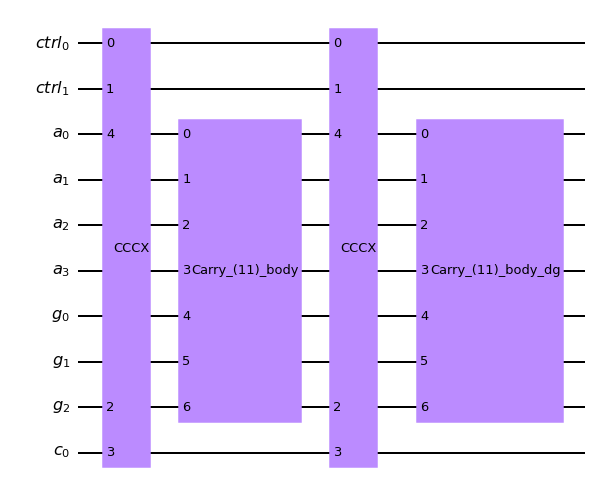

In [4]:
_qrCtrl = QuantumRegister(2, name='ctrl')
_qrA = QuantumRegister(4, name='a')
_qrG = QuantumRegister(3, name='g')
_qrC = QuantumRegister(1, name='c')

_qc = QuantumCircuit(_qrCtrl, _qrA, _qrG, _qrC)

carry = double_controlled_carry(11, 4)

_qc.append(carry, _qrCtrl[:] + _qrA[:] + _qrG[:] + _qrC[:])
_qc.decompose().draw(output='mpl')

In [5]:
from utils.bits import as_bits

def init(ctrl, a, g, n):    
    qrCtrl = QuantumRegister(2, name='ctrl')
    qrA = QuantumRegister(n, name='a')
    qrG = QuantumRegister(n-1 if n >=2 else 1, name='g')
    qrC = QuantumRegister(1, name='c')
    qc = QuantumCircuit(qrCtrl, qrA, qrG, qrC)
    
    for (qr, value, n) in [(qrCtrl, ctrl, 2), (qrA, a, n), (qrG, g, n)]:
        bits = as_bits(value, n)
        for i in range(n):
            if bits[n-(i+1)] == '1':
                qc.x(qr[i])

    qc.barrier(qrCtrl[:], qrA[:], qrG[:])
        
    return qc

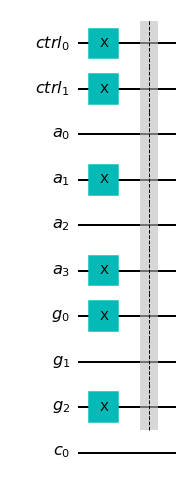

In [6]:
init(3, 10, 5, 4).draw(output='mpl')

In [7]:
def measure(n):
    qrA = QuantumRegister(n, name='a')
    qrC = QuantumRegister(1, name='c')
    crA = ClassicalRegister(n, name='aValue')
    crC = ClassicalRegister(1, name='cValue')
    
    qrG = QuantumRegister(n-1 if n>=2 else 1, name='g')
    crG = ClassicalRegister(n-1 if n>=2 else 1, name='gValue')
    
    qc = QuantumCircuit(qrA, qrG, qrC, crA, crG, crC)
    qc.barrier(qrA[:], qrG[:], qrC[:])
    qc.measure(qrA[:], crA[:])
    qc.measure(qrG[:], crG[:])
    qc.measure(qrC[:], crC[:])
    
    return qc

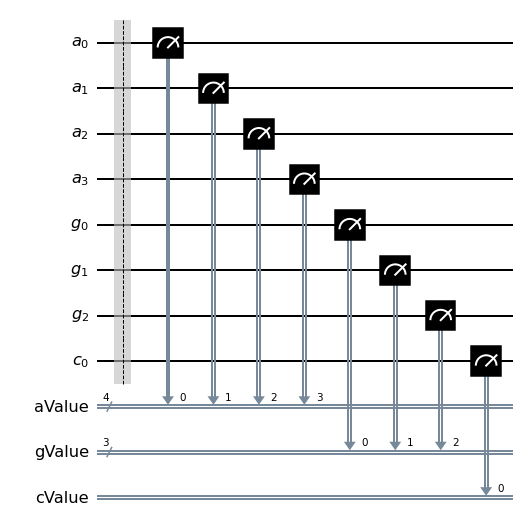

In [8]:
measure(4).draw(output='mpl')

In [9]:
def test_double_controlled_carry(ctrl, a, constant, n, carry):
    expected_carry = int((a + constant) / (2 ** n)) if ctrl == 3 else 0
    print(expected_carry, carry, expected_carry == carry)

In [10]:
test_double_controlled_carry(3, 6, 11, 4, 1)
test_double_controlled_carry(1, 6, 11, 4, 0)

1 1 True
0 0 True


In [11]:
from qiskit import Aer
from qiskit import execute

backend = Aer.get_backend('qasm_simulator')

In [12]:
def test(ctrl, a, g, constant, n):
    qrCtrl = QuantumRegister(2, name='ctrl')
    qrA = QuantumRegister(n, name='a')
    qrG = QuantumRegister(n-1 if n>=2 else 1, name='g')
    qrC = QuantumRegister(1, name='c')
    
    qc = QuantumCircuit(qrCtrl, qrA, qrG, qrC)
        
    qc += init(ctrl, a, g, n)
    
    qc.append(
        double_controlled_carry(constant, n),
        qrCtrl[:] + qrA[:] + qrG[:] + qrC[:]
    )
        
    qc += measure(n)

    job = execute(qc, backend, shots=1)
    result = job.result()
    values = list(result.get_counts(qc).keys())

    assert len(values) == 1
    values = [int(v, 2) for v in values[0].split(' ')]

    c_value = values[0]
    g_value = values[1]
    a_value = values[2]

    print(a, a_value, a == a_value)
    print(g, g_value, g == g_value)
    test_double_controlled_carry(ctrl, a, constant, n, c_value)
        
#     return qc

In [13]:
test(False, 6, 5, 11, 4)

<ipython-input-12-eb0291f73d71>:9: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  qc += init(ctrl, a, g, n)
/home/bartek/S10/MGR/masterThesisProject/venv/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


6 6 True
5 5 True
0 0 True


In [14]:
# for n in range(4):
#     n = n + 1
#     G = 2 ** (n-1)
#     N = 2 ** n
#     for a in range(N):
#         for g in range(G):
#             for c in range(N):
#                 for ctrl in reversed(range(4)):
#                     print('---', ctrl, '-', a, g, c, '---')
#                     test(ctrl == 1, a, g, c, n)